In [15]:
import numpy as np
import xarray as xr
from scipy import stats
import scipy
from scipy.stats import linregress
import netCDF4 as nc4
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import cartopy.crs as ccrs
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [16]:
font = {'family' : 'calibri',
       'weight': 'bold',
       'size': 20}
plt.rc('font', **font)
plt.rc('axes',edgecolor='k',linewidth=3)

In [17]:
# Function to filter the data

def nan_gaussian_filter(field,sigma):
    from scipy.ndimage import gaussian_filter
    field = np.double(field)    
    # Take the original field and replace the NaNs with zeros.
    field0 = field.copy()
    field0[np.isnan(field)] = 0
    ff = gaussian_filter(field0, sigma=sigma)
    # Create the smoothed weight field.
    weight = 0*field.copy()+1
    weight[np.isnan(field)] = 0
    ww = gaussian_filter(weight, sigma=sigma)
    zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
                        # was originally NaN.
    return zz


def mesh(lat,lon):
    mesh_lat = np.empty([len(lat),len(lon)])
    mesh_lon = np.empty([len(lat),len(lon)])
    for i in range(len(lat)):
        for j in range(len(lon)):
            mesh_lat[i,j] = lat[i]
            mesh_lon[i,j] = lon[j]
    return mesh_lat, mesh_lon



In [18]:
f1='/work/bb1153/b381639/NorESM/SHFLX_150_tropical_ocean.nc'
f2='/work/bb1153/b381639/NorESM/V10DT_150_tropical_ocean.nc'
fh=xr.open_dataset(f1)
fw=xr.open_dataset(f2)




In [19]:
sshf=fh.SHFLX
DT=fw.V10DT*1000. 

sshf_s=xr.zeros_like(sshf)
sshf_r=xr.zeros_like(sshf)


DT_s=xr.zeros_like(DT)
DT_r=xr.zeros_like(DT)



In [20]:
 # Compute smoothed and residual fields

for j in range(sshf.shape[0]):

    sshf_s[j,:,:] = nan_gaussian_filter(sshf.data[j,:,:],5)
    DT_s[j,:,:] = nan_gaussian_filter(DT.data[j,:,:],5)

/tmp/ipykernel_1958841/2705051551.py:14: RuntimeWarning: divide by zero encountered in true_divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field
/tmp/ipykernel_1958841/2705051551.py:14: RuntimeWarning: invalid value encountered in true_divide
  zz = ff/(ww*weight) # This rescale for the actual weights used in the filter and set to NaN where the field


In [21]:
sshf_r=sshf-sshf_s
DT_r=DT-DT_s

(array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.,  20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


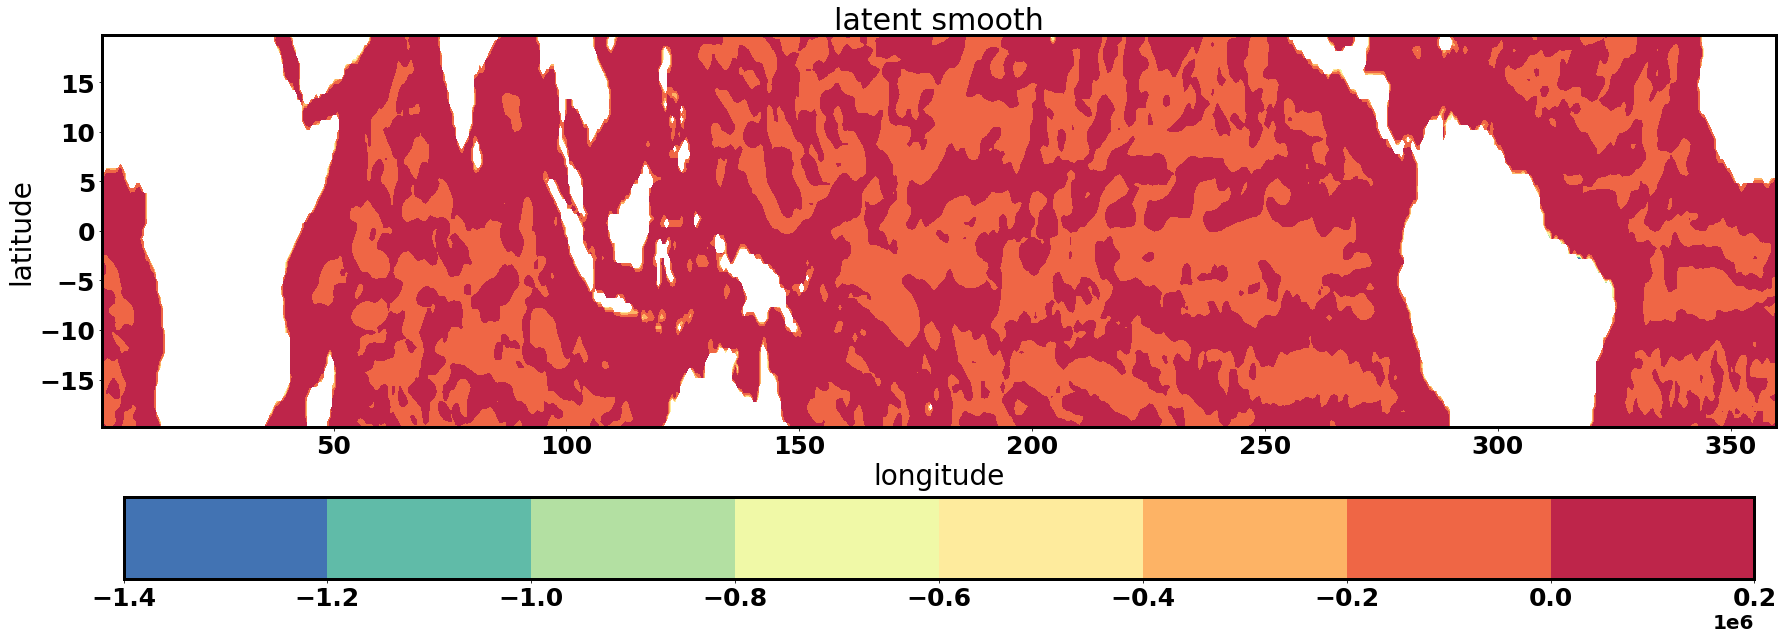

In [22]:

######################
#plot a map lat vs Lon
########################
########
#(1) get x-axis and y axis
arr=DT_r #ar.DataArray.from_iris(ERA5) # iris cube to xarray
latm=arr.latitude.data              # latm is x-axis
lonm=arr.longitude.data #+ 180             # lonm is y-axis  
#print(arr[0,0,:].data)

  
#arr = np.roll(arr, 720, axis = 2)
##################
#(2)set color bar and prepare fig size
#levels1=np.arange(0,300,30) # min and max of the field; dont use it if not sure
levels1=np.arange(-5,5,.2) # min and max of the field; dont use it if not sure
#cbar='winter'
#levels1=np.arange(0.,18.,1.) # min and max of the field; dont use it if not sure
#cbar='ocean'
#cbar='jet'
#cbar='Reds'
#cbar='YlGnBu'
#cbar='rainbow'
cbar='Spectral_r'
#cbar='YlOrRd'
plt.figure(figsize=(30,10))

########
#plot the figure
#plt.contourf(lonm,latm,arr[0,:,:],levels=levels1,cmap = cbar)
plt.contourf(lonm,latm,arr[300,:,:],cmap = cbar)
#plt.title('SST- ICON 5N-5S daily from 20/1/2020')

plt.title('latent smooth',fontsize=30)
cbar=plt.colorbar(orientation='horizontal', pad=0.13)
cbar.ax.tick_params(labelsize = 25)
        

        
plt.xlabel(('longitude'), fontsize=28)
plt.ylabel(('latitude'), fontsize=28)
plt.xticks(fontsize=25)#, rotation=90)
plt.yticks(fontsize=25)#, rotation=90)

#####save figure
#plt.savefig('Sensible_ERA5.eps',format='eps',dpi=1000)


In [23]:



latm=DT.latitude.data              # latm is x-axis
lonm=DT.longitude.data

l_u_r = np.empty([5,len(latm),len(lonm)])

for i in range(len(latm)):
    for j in range(len(lonm)):
        u_stats_tot    = DT_r[:,i,j]
        sshf_stats_tot = sshf_r[:,i,j]  
        mask_u_tot = ~np.isnan(sshf_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        

        vary_u_tot = sshf_stats_tot[mask_u_tot]
        varx_u_tot = u_stats_tot[mask_u_tot]

        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            l_u_r[:,i,j] = np.nan * np.ones(5)
        
        else:
            l_u_r[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)

In [33]:
latm=DT.latitude.data              # latm is x-axis
lonm=DT.longitude.data

l_u_s = np.empty([5,len(latm),len(lonm)])

for i in range(len(latm)):
    for j in range(len(lonm)):
        u_stats_tot    = DT_s[:,i,j]
        sshf_stats_tot = sshf_s[:,i,j]  
#        mask_u_tot = ~np.isnan(slhf_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        mask_u_tot = ~np.isinf(sshf_stats_tot[:]) & ~np.isinf(u_stats_tot[:])

        vary_u_tot = sshf_stats_tot[mask_u_tot]
        varx_u_tot = u_stats_tot[mask_u_tot]

        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            l_u_s[:,i,j] = np.nan * np.ones(5)
        
        else:
            l_u_s[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)



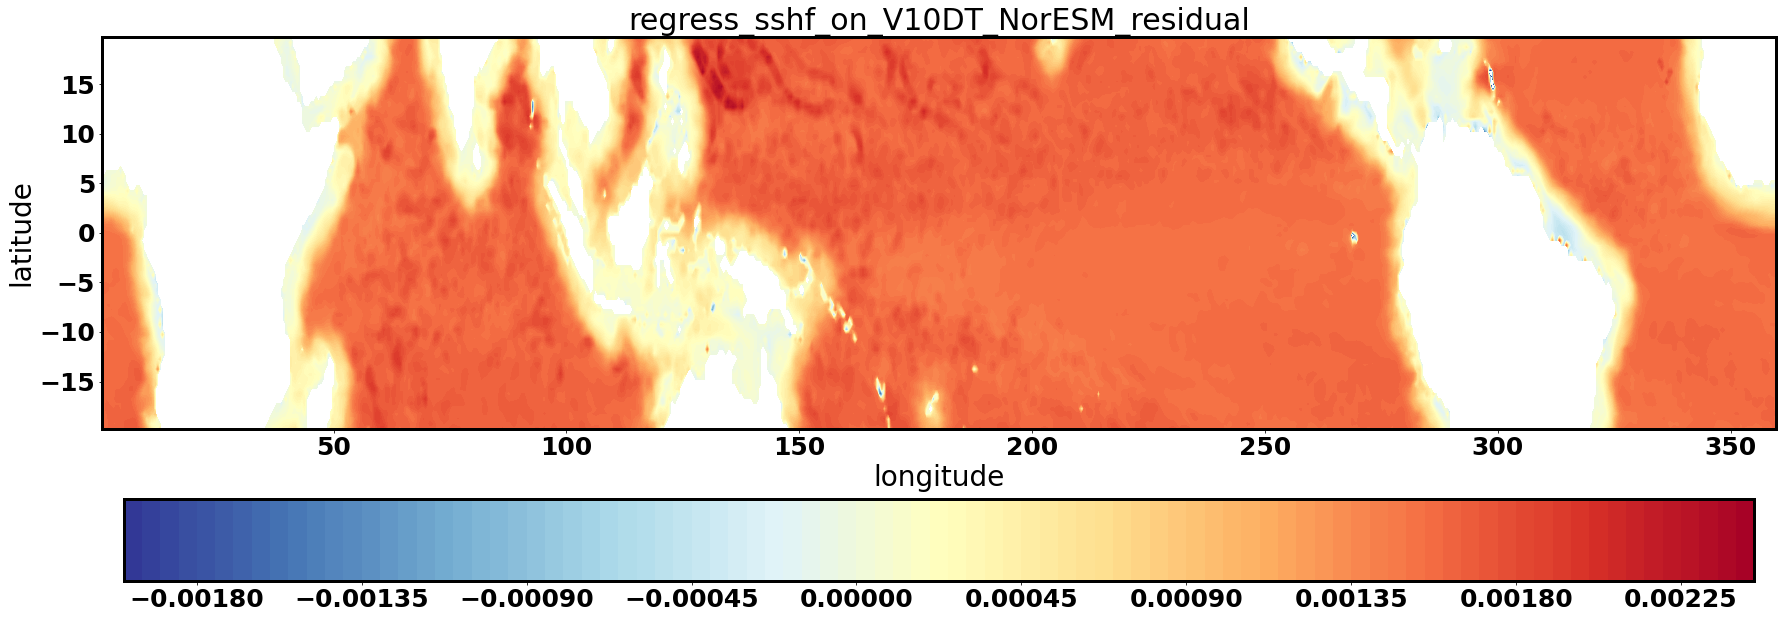

In [32]:
######################
#plot a map lat vs Lon
########################
########
#(1) get x-axis and y axis
arr=sshf #ar.DataArray.from_iris(ERA5) # iris cube to xarray
latm=arr.latitude.data              # latm is x-axis
lonm=arr.longitude.data #+ 180             # lonm is y-axis  
#print(arr[0,0,:].data)

  
#arr = np.roll(arr, 720, axis = 2)
##################
#(2)set color bar and prepare fig size
#levels1=np.arange(0,300,30) # min and max of the field; dont use it if not sure
levels1=np.arange(-.002,.0025,.00005)# min and max of the field; dont use it if not sure
#cbar='winter'
#levels1=np.arange(0.,18.,1.) # min and max of the field; dont use it if not sure
#cbar='ocean'
#cbar='jet'
#cbar='Reds'
#cbar='YlGnBu'
#cbar='rainbow'
#cbar='Spectral_r'
#cbar='YlOrRd'
cbar='RdYlBu_r'
plt.figure(figsize=(30,10))

########
#plot the figure
plt.contourf(lonm,latm,l_u_r[0,:,:],levels=levels1,cmap = cbar)
#plt.contourf(lonm,latm,l_u_r[0,:,:],cmap = cbar)
#plt.title('SST- ICON 5N-5S daily from 20/1/2020')

plt.title('regress_sshf_on_V10DT_NorESM_residual',fontsize=30)
cbar=plt.colorbar(orientation='horizontal', pad=0.13)
cbar.ax.tick_params(labelsize = 25)
        

        
plt.xlabel(('longitude'), fontsize=28)
plt.ylabel(('latitude'), fontsize=28)
plt.xticks(fontsize=25)#, rotation=90)
plt.yticks(fontsize=25)#, rotation=90)

#####save figure
plt.savefig('regress_sshf_on_V10DT_NorESM_r.eps',format='eps',dpi=1000)



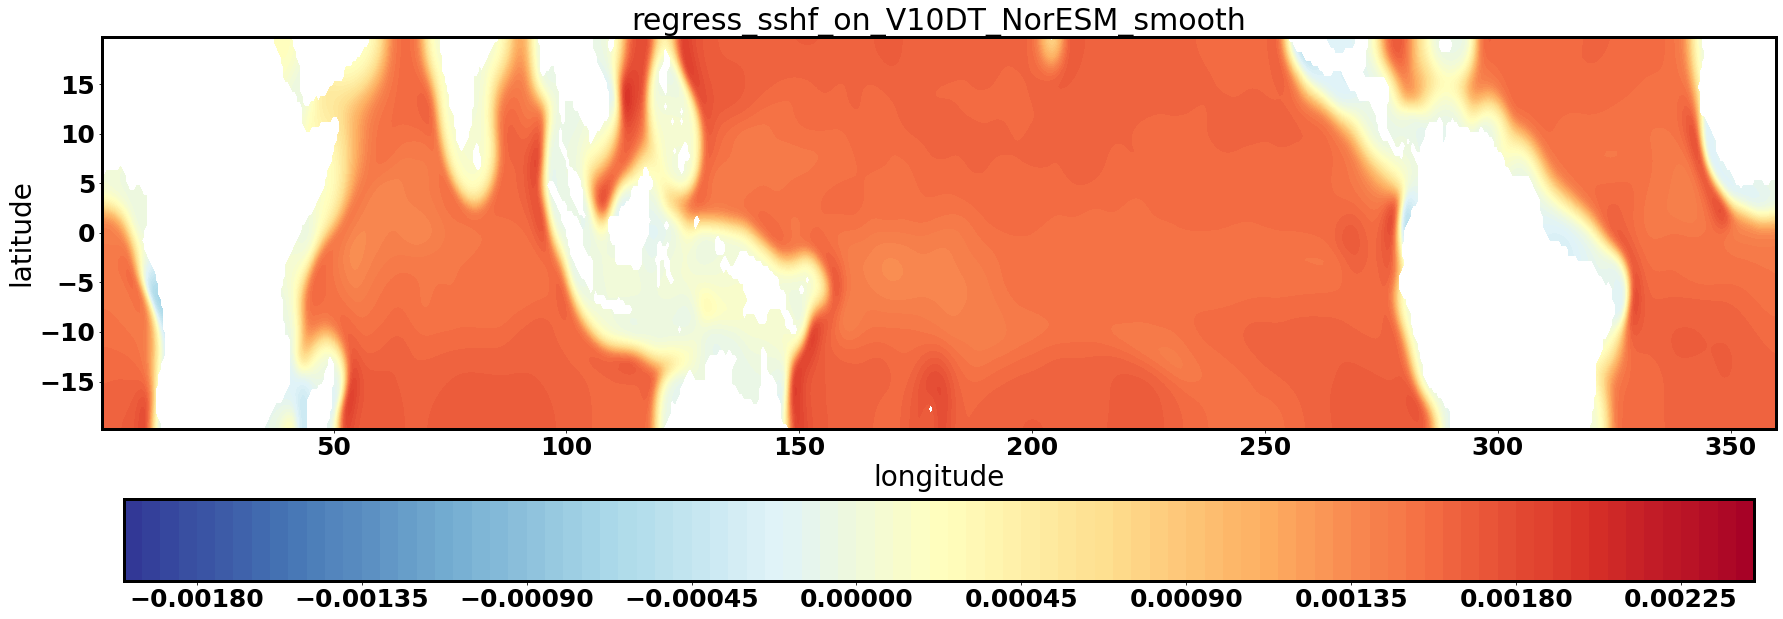

In [34]:
######################
#plot a map lat vs Lon
########################
########
#(1) get x-axis and y axis
arr=sshf #ar.DataArray.from_iris(ERA5) # iris cube to xarray
latm=arr.latitude.data              # latm is x-axis
lonm=arr.longitude.data #+ 180             # lonm is y-axis  
#print(arr[0,0,:].data)

  
#arr = np.roll(arr, 720, axis = 2)
##################
#(2)set color bar and prepare fig size
#levels1=np.arange(0,300,30) # min and max of the field; dont use it if not sure
levels1=np.arange(-.002,.0025,.00005) # min and max of the field; dont use it if not sure
#cbar='winter'
#levels1=np.arange(0.,18.,1.) # min and max of the field; dont use it if not sure
#cbar='ocean'
#cbar='jet'
#cbar='Reds'
#cbar='YlGnBu'
#cbar='rainbow'
#cbar='Spectral_r'
cbar='RdYlBu_r'
plt.figure(figsize=(30,10))

########
#plot the figure
plt.contourf(lonm,latm,l_u_s[0,:,:],levels=levels1,cmap = cbar)
#plt.contourf(lonm,latm,l_u_s[0,:,:],cmap = cbar)
#plt.title('SST- ICON 5N-5S daily from 20/1/2020')

plt.title('regress_sshf_on_V10DT_NorESM_smooth',fontsize=30)
cbar=plt.colorbar(orientation='horizontal', pad=0.13)
cbar.ax.tick_params(labelsize = 25)
        

        
plt.xlabel(('longitude'), fontsize=28)
plt.ylabel(('latitude'), fontsize=28)
plt.xticks(fontsize=25)#, rotation=90)
plt.yticks(fontsize=25)#, rotation=90)

#####save figure
plt.savefig('regress_sshf_on_V10DT_NorESM_s.eps',format='eps',dpi=1000)


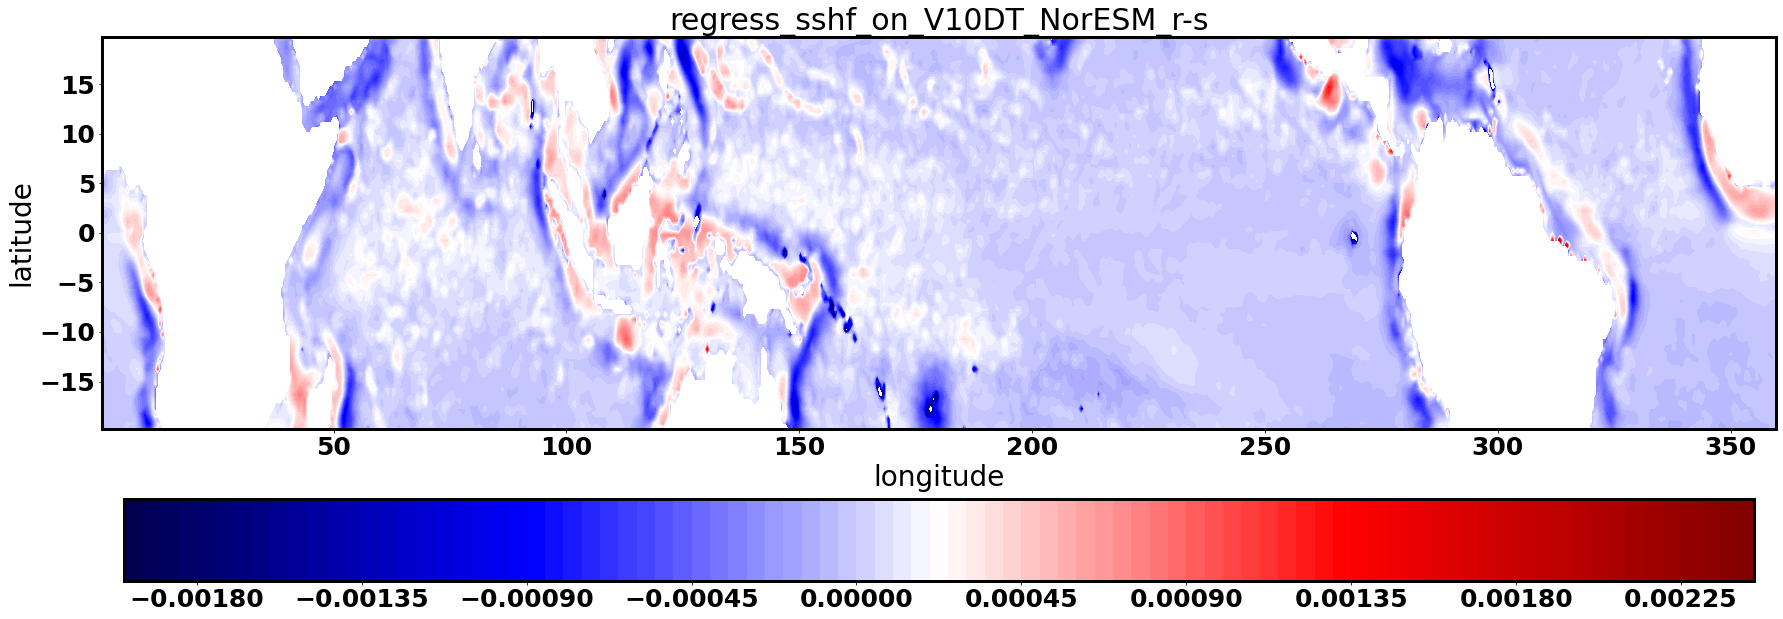

In [35]:
Hbias=l_u_r[0,:,:]-l_u_s[0,:,:]

######################
#plot a map lat vs Lon
########################
########
#(1) get x-axis and y axis
arr=sshf #ar.DataArray.from_iris(ERA5) # iris cube to xarray
latm=arr.latitude.data              # latm is x-axis
lonm=arr.longitude.data #+ 180             # lonm is y-axis  
#print(arr[0,0,:].data)

  
#arr = np.roll(arr, 720, axis = 2)
##################
#(2)set color bar and prepare fig size
#levels1=np.arange(0,300,30) # min and max of the field; dont use it if not sure
levels1=np.arange(-.002,.0025,.00005) # min and max of the field; dont use it if not sure
#cbar='winter'
#levels1=np.arange(0.,18.,1.) # min and max of the field; dont use it if not sure
#cbar='ocean'
#cbar='jet'
#cbar='Reds'
#cbar='YlGnBu'
#cbar='rainbow'
#cbar='Spectral_r'
cbar='seismic'
plt.figure(figsize=(30,10))

########
#plot the figure
plt.contourf(lonm,latm,Hbias,levels=levels1,cmap = cbar)
#plt.contourf(lonm,latm,l_u_s[0,:,:],cmap = cbar)
#plt.title('SST- ICON 5N-5S daily from 20/1/2020')

plt.title('regress_sshf_on_V10DT_NorESM_r-s',fontsize=30)
cbar=plt.colorbar(orientation='horizontal', pad=0.13)
cbar.ax.tick_params(labelsize = 25)
        

        
plt.xlabel(('longitude'), fontsize=28)
plt.ylabel(('latitude'), fontsize=28)
plt.xticks(fontsize=25)#, rotation=90)
plt.yticks(fontsize=25)#, rotation=90)

#####save figure
plt.savefig('regress_sshf_on_V10DT_NorESM_r-s.eps',format='eps',dpi=1000)

In [ ]:
for i in range(len(latm)):
    for j in range(len(lonm)):
        u_stats_tot    = wsp_r[:,i,j]
        slhf_stats_tot = slhf_r[:,i,j]  
        mask_u_tot = ~np.isnan(slhf_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        
    
        varx_q_tot = sst_stats_tot[mask_q_tot]
        vary_q_tot = q_stats_tot[mask_q_tot]

        varx_u_tot = sst_stats_tot[mask_u_tot]
        vary_u_tot = u_stats_tot[mask_u_tot]
   
    
        if ((varx_q_tot.shape[0])) == 0 or ((vary_q_tot.shape[0]) == 0):
            m_q_sf[:,i,j] = np.nan *  np.ones(5)
        
        else:
            m_q_sf[:,i,j] = scipy.stats.linregress(varx_q_tot,vary_q_tot)                   
            
        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            m_u_sf[:,i,j] = np.nan * np.ones(5)
        
        else:
            m_u_sf[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)
                   

In [8]:
# Compute slopes for all the datasets (smoothed and residual fields)

m_u_sf = np.empty([5,len(lat_sf),len(lon_sf)])
m_q_sf = np.empty([5,len(lat_sf),len(lon_sf)])
m_u_era5 = np.empty([5,len(lat_era5),len(lon_era5)])
m_q_era5 = np.empty([5,len(lat_era5),len(lon_era5)])

for i in range(len(lat_sf)):
    for j in range(len(lon_sf)):
        u_stats_tot = wspd10m_sf_residual[:,i,j]
        sst_stats_tot = sst_sf_residual[:,i,j]
        q_stats_tot = qair2m_sf_residual[:,i,j]

        mask_q_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(q_stats_tot[:])
        mask_u_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        
    
        varx_q_tot = sst_stats_tot[mask_q_tot]
        vary_q_tot = q_stats_tot[mask_q_tot]

        varx_u_tot = sst_stats_tot[mask_u_tot]
        vary_u_tot = u_stats_tot[mask_u_tot]
   
    
        if ((varx_q_tot.shape[0])) == 0 or ((vary_q_tot.shape[0]) == 0):
            m_q_sf[:,i,j] = np.nan *  np.ones(5)
        
        else:
            m_q_sf[:,i,j] = scipy.stats.linregress(varx_q_tot,vary_q_tot)                   
            
        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            m_u_sf[:,i,j] = np.nan * np.ones(5)
        
        else:
            m_u_sf[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)
                   

# Do the same for ERA5
for i in range(len(lat_era5)):
    for j in range(len(lon_era5)):
        u_stats_tot = wspd10m_era5_residual[:,i,j]
        sst_stats_tot = sst_era5_residual[:,i,j]
        q_stats_tot = qair2m_era5_residual[:,i,j]

        mask_q_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(q_stats_tot[:])
        mask_u_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        
    
        varx_q_tot = sst_stats_tot[mask_q_tot]
        vary_q_tot = q_stats_tot[mask_q_tot]

        varx_u_tot = sst_stats_tot[mask_u_tot]
        vary_u_tot = u_stats_tot[mask_u_tot]

    
        if ((varx_q_tot.shape[0])) == 0 or ((vary_q_tot.shape[0]) == 0):
            m_q_era5[:,i,j] = np.nan *  np.ones(5)
        
        else:
            m_q_era5[:,i,j] = scipy.stats.linregress(varx_q_tot,vary_q_tot)                   
            
        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            m_u_era5[:,i,j] = np.nan * np.ones(5)
        
        else:
            m_u_era5[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)

# Same for the smoothed fields

m_u_s_sf = np.empty([5,len(lat_sf),len(lon_sf)])
m_q_s_sf = np.empty([5,len(lat_sf),len(lon_sf)])
m_u_s_era5 = np.empty([5,len(lat_era5),len(lon_era5)])
m_q_s_era5 = np.empty([5,len(lat_era5),len(lon_era5)])



for i in range(len(lat_sf)):
    for j in range(len(lon_sf)):
        u_stats_tot = wspd10m_sf_smoothed[:,i,j]
        sst_stats_tot = sst_sf_smoothed[:,i,j]
        q_stats_tot = qair2m_sf_smoothed[:,i,j]


        mask_q_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(q_stats_tot[:])
        mask_u_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
        
    
        varx_q_tot = sst_stats_tot[mask_q_tot]
        vary_q_tot = q_stats_tot[mask_q_tot]

        varx_u_tot = sst_stats_tot[mask_u_tot]
        vary_u_tot = u_stats_tot[mask_u_tot]
   
    
        if ((varx_q_tot.shape[0])) == 0 or ((vary_q_tot.shape[0]) == 0):
            m_q_s_sf[:,i,j] = np.nan *  np.ones(5)
        
        else:
            m_q_s_sf[:,i,j] = scipy.stats.linregress(varx_q_tot,vary_q_tot)                   
            
        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            m_u_s_sf[:,i,j] = np.nan * np.ones(5)
        
        else:
            m_u_s_sf[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)            
            
# Again for ERA5

for i in range(len(lat_era5)):
    for j in range(len(lon_era5)):
        u_stats_tot = wspd10m_era5_smoothed[:,i,j]
        sst_stats_tot = sst_era5_smoothed[:,i,j]
        q_stats_tot = qair2m_era5_smoothed[:,i,j]

        mask_q_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(q_stats_tot[:])
        mask_u_tot = ~np.isnan(sst_stats_tot[:]) & ~np.isnan(u_stats_tot[:])
            
        varx_q_tot = sst_stats_tot[mask_q_tot]
        vary_q_tot = q_stats_tot[mask_q_tot]

        varx_u_tot = sst_stats_tot[mask_u_tot]
        vary_u_tot = u_stats_tot[mask_u_tot]
   
    
        if ((varx_q_tot.shape[0])) == 0 or ((vary_q_tot.shape[0]) == 0):
            m_q_s_era5[:,i,j] = np.nan *  np.ones(5)
        
        else:
            m_q_s_era5[:,i,j] = scipy.stats.linregress(varx_q_tot,vary_q_tot)                   
            
        if ((varx_u_tot.shape[0])) == 0 or ((vary_u_tot.shape[0]) == 0):
                    
            m_u_s_era5[:,i,j] = np.nan * np.ones(5)
        
        else:
            m_u_s_era5[:,i,j] = scipy.stats.linregress(varx_u_tot,vary_u_tot)
            

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.
findfont: Font family ['calibri'] not found. Falling back to DejaVu Sans.


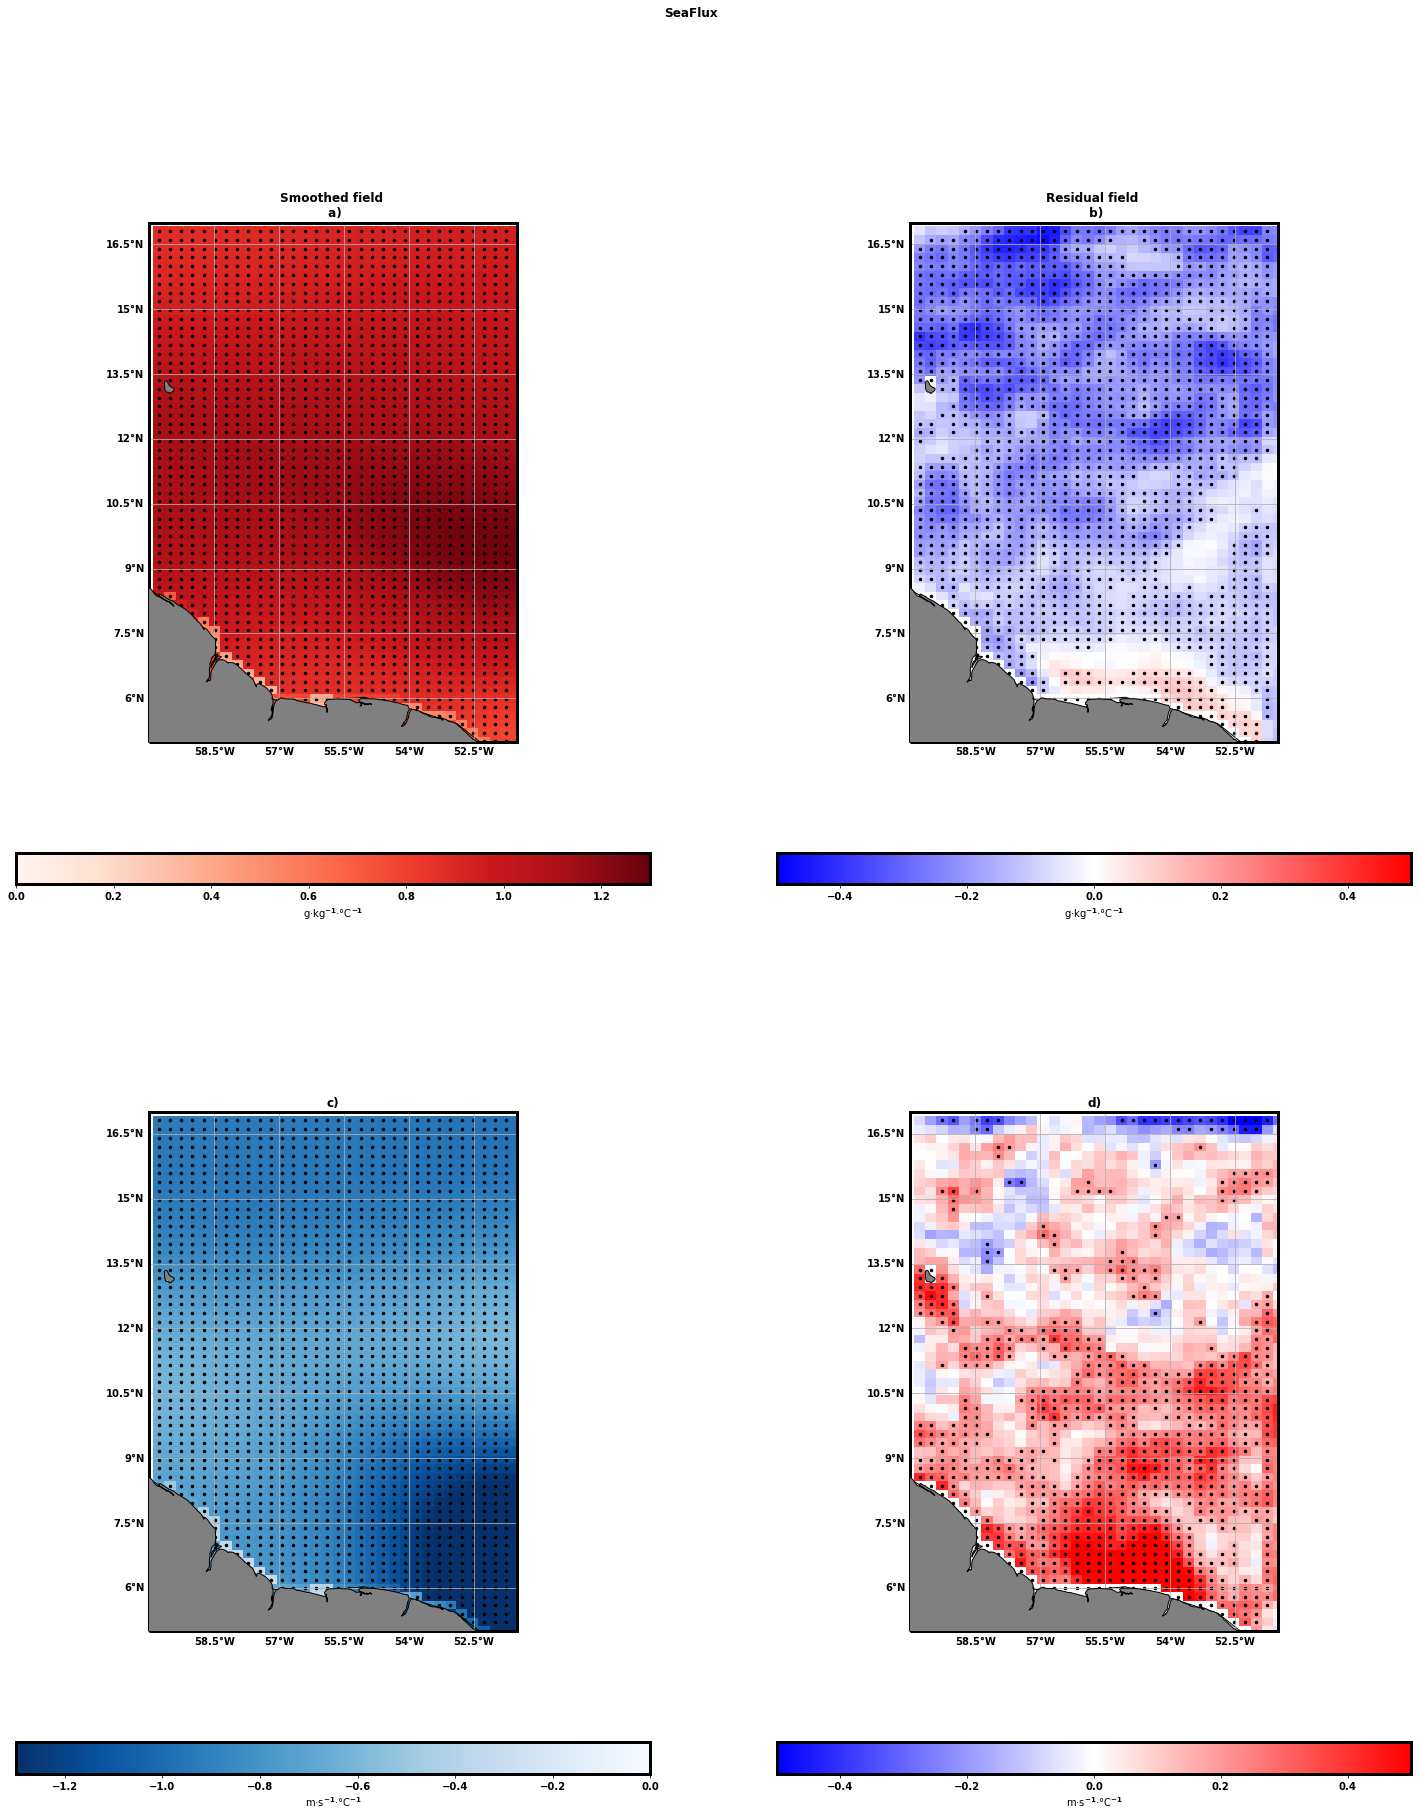

In [9]:
# Plot the coefficients 

#######################################

# SeaFlux

#######################################

lat_central = lat_sf
lon_central = lon_sf
Lat_central, Lon_central = mesh(lat_sf,lon_sf)


figTS,axs = plt.subplots(2,2,figsize=(25,30), subplot_kw={'projection': ccrs.PlateCarree(180)})
lev_1 = np.arange(-1,1.2,0.2)
lev_2 = np.arange(-1,1.2,0.2)

        
plt.suptitle('SeaFlux' ,weight='bold')
        
cs_1 = axs[0,0].pcolormesh(np.asarray(lon_central),np.asarray(lat_central),(m_q_s_sf[0,:,:]),#,levels = lev_1,
               transform=ccrs.PlateCarree(),cmap='Reds',vmin = 0, vmax = 1.3)
        
        
LON_central = ma.masked_where(m_q_s_sf[3,:,:]>0.01, (Lon_central))
LAT_central = ma.masked_where(m_q_s_sf[3,:,:]>0.01, (Lat_central))


hatch = axs[0,0].plot(np.transpose(LON_central+180),np.transpose(LAT_central),'.',color='black',markersize=5)
        
cs_2 = axs[0,1].pcolormesh(np.asarray(lon_central),np.asarray(lat_central),(m_q_sf[0,:,:]),#,levels = lev_1,
               transform=ccrs.PlateCarree(),cmap='bwr',vmin = -0.5, vmax = 0.5)
        
LON_central = ma.masked_where(m_q_sf[3,:,:]>0.01, (Lon_central))
LAT_central = ma.masked_where(m_q_sf[3,:,:]>0.01, (Lat_central))

hatch = axs[0,1].plot(np.transpose(LON_central+180),np.transpose(LAT_central),'.',color='black',markersize=5)
        
cs_3 = axs[1,0].pcolormesh(np.asarray(lon_central),np.asarray(lat_central),(np.asarray(m_u_s_sf[0,:,:])), #,levels = lev_1,
               transform=ccrs.PlateCarree(),cmap='Blues_r',vmin = -1.3, vmax  =0)
        
LON_central = ma.masked_where(m_u_s_sf[3,:,:]>0.01, (Lon_central))
LAT_central = ma.masked_where(m_u_s_sf[3,:,:]>0.01, (Lat_central))

hatch = axs[1,0].plot(np.transpose(LON_central)+180,np.transpose(LAT_central),'.',color='black',markersize=5)
        
cs_4 = axs[1,1].pcolormesh(np.asarray(lon_central),np.asarray(lat_central),(np.asarray(m_u_sf[0,:,:])), #,levels = lev_1,
               transform=ccrs.PlateCarree(),cmap='bwr',vmin = -0.5, vmax = 0.5)
        
LON_central = ma.masked_where(m_u_sf[3,:,:]>0.01, (Lon_central))
LAT_central = ma.masked_where(m_u_sf[3,:,:]>0.01, (Lat_central))

hatch = axs[1,1].plot(np.transpose(LON_central)+180,np.transpose(LAT_central),'.',color='black',markersize=5)

plt.colorbar(cs_1,ax=axs[0,0],orientation='horizontal',label='g·kg$^{-1}$·°C$^{-1}$')
plt.colorbar(cs_2,ax=axs[0,1],orientation = 'horizontal',label='g·kg$^{-1}$·°C$^{-1}$')
plt.colorbar(cs_3,ax=axs[1,0],orientation='horizontal',label='m·s$^{-1}$·°C$^{-1}$')
plt.colorbar(cs_4,ax=axs[1,1],orientation='horizontal',label='m·s$^{-1}$·°C$^{-1}$')

axs[0,0].set_xlim(-60+180,-51.5+180)
axs[1,0].set_xlim(-60+180,-51.5+180)
axs[0,1].set_xlim(-60+180,-51.5+180)
axs[1,1].set_xlim(-60+180,-51.5+180)

axs[0,0].set_ylim(5,17)
axs[1,0].set_ylim(5,17)
axs[0,1].set_ylim(5,17)
axs[1,1].set_ylim(5,17)
        
        
axs[0,0].set_title('Smoothed field \n a)',weight='bold')
axs[0,1].set_title('Residual field \n b)',weight='bold')
axs[1,0].set_title(r'c)', weight='bold')
axs[1,1].set_title(r'd)',weight='bold')
        
axs[0,0].add_feature(cartopy.feature.LAND,facecolor='gray',zorder=100, edgecolor='k')
axs[0,1].add_feature(cartopy.feature.LAND,facecolor='gray',zorder=100, edgecolor='k')
axs[1,0].add_feature(cartopy.feature.LAND,facecolor='gray',zorder=100, edgecolor='k')
axs[1,1].add_feature(cartopy.feature.LAND,facecolor='gray',zorder=100, edgecolor='k')
        
cs = axs[0,0].coastlines(resolution='110m', linewidth=1)
cs = axs[0,1].coastlines(resolution='110m', linewidth=1)
cs = axs[1,0].coastlines(resolution='110m', linewidth=1)
cs = axs[1,1].coastlines(resolution='110m', linewidth=1)
        
gl = axs[0,0].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

gl = axs[0,1].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
        
gl = axs[1,0].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
        
gl = axs[1,1].gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
        
plt.savefig('./Prueba_1.jpg')
